In [1]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
import time
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
def getCurrentAvailability(kept_car_parks_df, info_df=pd.DataFrame()):
    # gets current availability from Singapore Government's 'Carpark Availability' API
    response = requests.get('https://api.data.gov.sg/v1/transport/carpark-availability')
    parking_availability = response.json()['items'][0]
    timestamp = parking_availability['timestamp']
    df = pd.DataFrame(parking_availability['carpark_data'])
    # Seperate info into arrays, as pandas isn't seperating them properly
    total_lots = []
    lot_type = []
    lots_available = []
    for carpark_info in parking_availability['carpark_data']:
        total_lots.append(carpark_info['carpark_info'][0]['total_lots'])
        lot_type.append(carpark_info['carpark_info'][0]['lot_type'])
        lots_available.append(carpark_info['carpark_info'][0]['lots_available'])
    # Add the new columns and delete the unneeded one
    df['total_lots'] = total_lots
    df['lot_type'] = lot_type
    df['lots_available'] = lots_available
    df = df.drop(['carpark_info'], axis=1)
    df = df[df['lot_type'] == 'C']
    df.reset_index()
    return df

kept_car_parks_df = pd.read_csv('selected_carparks.csv')
info_df = pd.read_csv('hdb-carpark-information-with-lat-lng.csv')
df = getCurrentAvailability(kept_car_parks_df)
# merges the availability dataframe with the iformation dataframe
merged_df = pd.merge(df, info_df, left_on=['carpark_number'], right_on=['carpark_number'])

In [6]:
merged_df

,carpark_number,update_datetime,total_lots,lot_type,lots_available,Unnamed: 0,address,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,gantry_height,car_park_basement,lat,lng
0,HE12,2021-05-07T03:20:44,91,C,7,236,BLK 78/81 REDHILL LANE,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,4.50,N,1.288210,103.818651
1,HLM,2021-05-07T03:20:47,583,C,470,245,BLK 533A HONG LIM MSCP,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,11,1.90,N,1.284852,103.845519
2,RHM,2021-05-07T03:20:44,322,C,72,438,BLK 88A REDHILL CLOSE,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,10,1.90,N,1.286464,103.818578
3,BM29,2021-05-07T03:20:52,97,C,86,133,BLK 163 BUKIT MERAH CENTRAL,BASEMENT CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,1,2.00,Y,1.283635,103.817099
4,Q81,2021-05-07T03:20:41,96,C,73,433,BLK 43 HOLLAND DRIVE,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,0,9.99,N,1.307537,103.793164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,MP2,2021-05-07T03:08:04,268,C,142,376,BLK 5 TO 8 MARINE TERRACE,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,4.50,N,1.304225,103.916658
712,MP5,2021-05-07T03:10:13,162,C,98,377,BLK 52/57 MARINE TERRACE,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,0,0.00,N,1.306110,103.916165
713,MP5M,2021-05-07T03:08:25,159,C,28,378,BLK 47A MARINE CRESCENT,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,2,2.15,N,1.305448,103.912478
714,MP5S,2021-05-07T03:08:24,33,C,8,379,BLK 45 MARINE CRESCENT,SURFACE CAR PARK,ELECTRONIC PARKING,7AM-10.30PM,NO,NO,0,4.50,N,1.304672,103.912569


In [7]:
merged_df.free_parking.unique()

array(['SUN & PH FR 7AM-10.30PM', 'NO', 'SUN & PH FR 1PM-10.30PM'],
      dtype=object)

In [4]:
merged_df.transpose().to_json('hdb-carpark-information.json')

In [5]:
# Find out approximately how many have been updated in the last 15 minutes
# So only those can be used, rather than ones that are not being updated very frequently
df[df['update_datetime'].str.contains('2019-08-12T06:4')].count()

carpark_number     0
update_datetime    0
total_lots         0
lot_type           0
lots_available     0
Unnamed: 0         0
dtype: int64

In [59]:
# FOR BACKEND
import requests
import pandas as pd
import numpy as np
import datetime as dt
import time
from pytz import timezone
import os

def getSequenceFromCurrentTime(minutes_in_future=210, minute_increments=15):
    # creates a list of dataframes, that is
    # each taken from the api at minute_increments apart from each other
    # until the minutes_in_future is reached, then returns the list of dataframes
    response = requests.get('https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2019-08-12T06%3A45%3A13')
    singapore_timezone = timezone('Asia/Singapore')
    parking_availability = response.json()['items'][0]
    timestamp = parking_availability['timestamp']
    df = pd.DataFrame(parking_availability['carpark_data'])
    info_df = pd.read_csv('hdb-carpark-information.csv')
    # starting date of the sequence (adding 10 in case exception is thrown)
    start_date = dt.datetime.now(singapore_timezone) - dt.timedelta(minutes=minutes_in_future)
    # end date would be current date as it is the last availability in the sequence
    end_date = dt.datetime.now(singapore_timezone)
    start_date_time = start_date.strftime('%y-%m-%dT%H:%M:%S')
    end_date_time = end_date.strftime('%y-%m-%dT%H:%M:%S')
    # Getting all the dataframes
    date = start_date
    info_df = pd.read_csv('hdb-carpark-information-with-lat-lng.csv')
    n_iterations = 0
    df_list = []
    while(date <= end_date):
        try:
            request_string = 'https://api.data.gov.sg/v1/transport/carpark-availability?date_time=%s' % (date.strftime('20%y-%m-%dT%H:%M:%S'))
            print(request_string)
            response = requests.get(request_string)
            parking_availability = response.json()['items'][0]
            timestamp = parking_availability['timestamp']
            df = pd.DataFrame(parking_availability['carpark_data'])
            total_lots = []
            lot_type = []
            lots_available = []
            for carpark_info in parking_availability['carpark_data']:
                total_lots.append(carpark_info['carpark_info'][0]['total_lots'])
                lot_type.append(carpark_info['carpark_info'][0]['lot_type'])
                lots_available.append(carpark_info['carpark_info'][0]['lots_available'])

            # Add year-month-day-hour-minutes-seconds columns
            df['year'] = date.year
            df['month'] = date.month
            df['day'] = date.day
            df['hour'] = date.hour
            df['minute'] = date.minute
            df['second'] = date.second
            # Add the new columns and delete the unneeded one
            df['total_lots'] = total_lots
            df['lot_type'] = lot_type
            df['lots_available'] = lots_available
            df = df.drop(['carpark_info'], axis=1)
            df = df[df['lot_type'] == 'C']
            df = pd.merge(df, info_df, left_on=['carpark_number'], right_on=['carpark_number'])
            df_list.append(df)
            print('date: ', date)
            print('count: ', df['carpark_number'].count(),'\n')
            n_iterations += 1
            date = date + dt.timedelta(minutes=15)
        except Exception as e:
            date = date + dt.timedelta(minutes=1)
            print(e)
    return df_list

df_list = getSequenceFromCurrentTime()

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2021-05-07T00:44:19
date:  2021-05-07 00:44:19.512136+08:00
count:  716 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2021-05-07T00:59:19
date:  2021-05-07 00:59:19.512136+08:00
count:  716 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2021-05-07T01:14:19
date:  2021-05-07 01:14:19.512136+08:00
count:  716 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2021-05-07T01:29:19
date:  2021-05-07 01:29:19.512136+08:00
count:  716 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2021-05-07T01:44:19
date:  2021-05-07 01:44:19.512136+08:00
count:  716 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2021-05-07T01:59:19
date:  2021-05-07 01:59:19.512136+08:00
count:  716 

https://api.data.gov.sg/v1/transport/carpark-availability?date_time=2021-05-07T02:14:19
date:  2021-05-07 02:14:19.512136+08:00
count:  716 

https:

In [65]:
len(df_list)

15

In [21]:
# Groups all the parking lots together and removes the ones that have a bad count
# combined_df = pd.read_csv('singapore_parking_data_2019-11-17_15_minute_interval.csv')
def sortDataframeList(df, merge_with_info=False, info_df=pd.DataFrame()):
    # combines the df_list into one dataframe, then sorts it
    # if merge_with_info is set to True, then the sorted df 
    # is merged with the info_df that is passed to the function
    combined_df_sorted = df.sort_values(by=['carpark_number', 'update_datetime'])
    combined_df_sorted = combined_df_sorted[combined_df_sorted['lot_type'] == 'C']
    combined_df_grouped = combined_df_sorted.groupby('carpark_number', axis=0)
    count_df = combined_df_grouped.count()
    keys_to_drop = count_df[count_df['update_datetime'] < (count_df.max()[0]-100)].index.to_list()
    combined_df_sorted = combined_df_sorted[~combined_df_sorted['carpark_number'].isin(keys_to_drop)]   
    return combined_df_sorted

#df = pd.read_csv('singapore_parking_data_2019-11-17_15_minute_interval.csv')
sorted_df = sortDataframeList(pd.concat(df_list), False)

In [94]:
# adding some extra features
def addFeaturesToDataframe(combined_df_sorted):
    # converts DataSeries into int then does the sin and cos transformation of each time unit
    combined_df_sorted['month_sin'] = np.sin(combined_df_sorted['month'].astype(int).to_numpy() * 2 * np.pi / 12)
    combined_df_sorted['month_cos'] = np.cos(combined_df_sorted['month'].astype(int).to_numpy() * 2 * np.pi / 12)
    combined_df_sorted['day_sin'] = np.sin(combined_df_sorted['day'].astype(int).to_numpy() * 2 * np.pi / 7)
    combined_df_sorted['day_cos'] = np.cos(combined_df_sorted['day'].astype(int).to_numpy() * 2 * np.pi / 7)
    combined_df_sorted['hour_sin'] = np.sin(combined_df_sorted['hour'].astype(int).to_numpy() * 2 * np.pi / 24)
    combined_df_sorted['hour_cos'] = np.cos(combined_df_sorted['hour'].astype(int).to_numpy() * 2 * np.pi / 24)
    combined_df_sorted['minute_sin'] = np.sin(combined_df_sorted['minute'].astype(int).to_numpy() * 2 * np.pi / 60)
    combined_df_sorted['minute_cos'] = np.cos(combined_df_sorted['minute'].astype(int).to_numpy() * 2 * np.pi / 60)

# seperates grouping into seperate lists by parking area
df_list_by_number = []
new_df = addFeaturesToDataframe(sorted_df)
combined_df_grouped = sorted_df.groupby('carpark_number', axis=0)
# Ignore the car park area and all take the dataframe
df_list_by_number = [area_and_df[1] for area_and_df in df_list_by_number]

In [127]:
# FOR BACKEND
def addFeaturesToDataframe(combined_df_sorted):
    # converts DataSeries into int then does the sin and cos transformation of each time unit
    combined_df_sorted['month_sin'] = np.sin(combined_df_sorted['month'].astype(int).to_numpy() * 2 * np.pi / 12)
    combined_df_sorted['month_cos'] = np.cos(combined_df_sorted['month'].astype(int).to_numpy() * 2 * np.pi / 12)
    combined_df_sorted['day_sin'] = np.sin(combined_df_sorted['day'].astype(int).to_numpy() * 2 * np.pi / 7)
    combined_df_sorted['day_cos'] = np.cos(combined_df_sorted['day'].astype(int).to_numpy() * 2 * np.pi / 7)
    combined_df_sorted['hour_sin'] = np.sin(combined_df_sorted['hour'].astype(int).to_numpy() * 2 * np.pi / 24)
    combined_df_sorted['hour_cos'] = np.cos(combined_df_sorted['hour'].astype(int).to_numpy() * 2 * np.pi / 24)
    combined_df_sorted['minute_sin'] = np.sin(combined_df_sorted['minute'].astype(int).to_numpy() * 2 * np.pi / 60)
    combined_df_sorted['minute_cos'] = np.cos(combined_df_sorted['minute'].astype(int).to_numpy() * 2 * np.pi / 60)
    
# FOR BACKEND
def sortDataframeList(df, merge_with_info=False, info_df=pd.DataFrame()):
    # combines the df_list into one dataframe, then sorts it
    # if merge_with_info is set to True, then the sorted df 
    # is merged with the info_df that is passed to the function
    combined_df_sorted = df.sort_values(by=['carpark_number', 'update_datetime'])
    combined_df_sorted = combined_df_sorted[combined_df_sorted['lot_type'] == 'C']
    combined_df_grouped = combined_df_sorted.groupby('carpark_number', axis=0)
    count_df = combined_df_grouped.count()
    keys_to_drop = count_df[count_df['update_datetime'] < (count_df.max()[0]-100)].index.to_list()
    combined_df_sorted = combined_df_sorted[~combined_df_sorted['carpark_number'].isin(keys_to_drop)]   
    return combined_df_sorted

# FOR BACKEND    
def modifyDataframeListForNN(df_list):
    sorted_df = sortDataframeList(pd.concat(df_list))
    df_list_by_number = []
    addFeaturesToDataframe(sorted_df)
    combined_df_grouped = sorted_df.groupby('carpark_number', axis=0)
    df_list_by_number = list(combined_df_grouped)
    # Ignore the car park area and all take the dataframe
    df_list_by_number = [area_and_df[1] for area_and_df in df_list_by_number]
    return df_list_by_number

df_list_for_nn = modifyDataframeListForNN(df_list)

63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
63    1.0
Name: day_cos, dtype: float64

In [ ]:
model = load_model('./trained_models/model_checkpoint_A11.h5')

In [133]:
from tensorflow.keras.models import load_model

# FOR BACKEND
def normalize(data):
    # normalize to a percentage (available/capacity)
    data_normalized = data / capacity
    return (data_normalized)

# FOR BACKEND
def generatePrediction(model, parking_area_df):
    features_selected = ['lots_available', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos']
    parking_area_df['lots_available'] = parking_area_df['lots_available'].astype(int).to_numpy()
    x = normalize(parking_area_df[features_selected].to_numpy())
    x = x.reshape(1, x.shape[0], len(features_selected))
    y = model.predict(x)
    return y

In [87]:
# Functions for normalizing and denormalizing
from sklearn import preprocessing

def normalize(data):
    # normalize to a percentage (available/capacity)
    data_normalized = data / capacity
    return (data_normalized)

def denormalize(mean, std, data_normalized):
    data = (data_normalized * std) + mean
    return data

# Stuff to modify parameters and NN
# Note: dataset is in increments of 15 mins
parking_area = 0 # Parking area to select from the list of parking areas
parking_area_df = df_list_by_number[parking_area].copy() # do not modify
training_split_fraction = 0.8 # modify train/test split
skip_row = 1 + 0 # number of rows to skip (+ 1 because skipping is 2 or above) 
                 # so, for example, skip_row = 2, df is in increments of 30 mins
                 # skip_row = 3, df is increments of 30 mins, etc.
past = 15 # Number of past lot availabiltiy in a sequence
future = 12 # predict future * 10 mins from current, so if future = 3, predicts 30 minutes into future
capacity = int(parking_area_df['total_lots'].iloc[0])
features_selected = ['lots_available', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos']

parking_area_df['lots_available'] = parking_area_df['lots_available'].astype(int)
available_normalized = normalize(parking_area_df['lots_available'].astype(int).to_numpy())
available_standardized = preprocessing.scale(parking_area_df['lots_available'].to_numpy())
parking_area_df = parking_area_df[::skip_row]
n_training = int(training_split_fraction * len(parking_area_df))
n_testing = len(parking_area_df) - n_training

df_features = parking_area_df[features_selected].to_numpy()
x = []
for i in range(past, len(parking_area_df)):
    x.append(df_features[i-past:i])

x = np.array(x[:len(parking_area_df)-past])
x = x.reshape(x.shape[0], x.shape[1], len(features_selected))
print(x.shape)

df_available = parking_area_df['lots_available'].to_numpy()
y = []
for i in range(future):
    y.append(df_available[past+(i):i-future])
    
y = np.array(y).T
x_normalized = normalize(x)
y_normalized = normalize(y)
x_train = normalize(x[:n_training])
x_test = normalize(x[n_training:])
y_train = normalize(y[:n_training])
# means and stds needed for y_test for de-normalization, but not needed for the rest
# note that denormalization should be removed if using percentage instead of original normalization
y_test = normalize(y[n_training:])

(1, 15, 7)


In [83]:
x_normalized

array([[[ 3.96739130e-01,  0.00000000e+00,  2.71739130e-03,
         -6.65568913e-19,  2.71739130e-03,  0.00000000e+00,
          2.71739130e-03],
        [ 3.96739130e-01,  0.00000000e+00,  2.71739130e-03,
         -6.65568913e-19,  2.71739130e-03,  2.71739130e-03,
          7.69774307e-19],
        [ 4.04891304e-01,  0.00000000e+00,  2.71739130e-03,
         -6.65568913e-19,  2.71739130e-03,  1.53954861e-18,
         -2.71739130e-03],
        [ 4.04891304e-01,  0.00000000e+00,  2.71739130e-03,
         -6.65568913e-19,  2.71739130e-03, -2.71739130e-03,
         -4.99176684e-19],
        [ 4.04891304e-01,  7.03312623e-04,  2.62479844e-03,
         -6.65568913e-19,  2.71739130e-03,  0.00000000e+00,
          2.71739130e-03],
        [ 4.04891304e-01,  7.03312623e-04,  2.62479844e-03,
         -6.65568913e-19,  2.71739130e-03,  2.71739130e-03,
          7.69774307e-19],
        [ 4.10326087e-01,  7.03312623e-04,  2.62479844e-03,
         -6.65568913e-19,  2.71739130e-03,  1.53954861e-18

In [17]:
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Concatenate, LSTM, SimpleRNN, GRU, Conv1D, Conv2D, Flatten, MaxPooling1D, MaxPooling2D, BatchNormalization, LayerNormalization, MultiHeadAttention, AdditiveAttention, Concatenate, GlobalMaxPooling1D, Attention, SeparableConv1D 
from tensorflow.keras import Sequential
# from tensorflow.keras.layers.core import Dense, Reshape, Lambda
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import datetime
from keras.wrappers.scikit_learn import KerasRegressor
from attention import Attention
import pickle 

    
def createModel(cnn, units, attention, loss, lr, epochs, pool_size=1, kernels=3, batchNormalization=False, dilation_rate=1):
    inputs = Input(shape=(x.shape[1], x.shape[2]))
    if (cnn):
        layer2 = Conv1D(units, kernels, dilation_rate = dilation_rate, activation='relu', padding='same')(inputs)
        # model.add(Conv2D(units, 3, activation='relu', input_shape=(x.shape[1], x.shape[2], x.shape[3])))
    else:
        layer2 = LSTM(units, input_shape=(x.shape[1], x.shape[2]), return_sequences=True)(inputs)
    if (attention):
        #layer3 = MultiHeadAttention(num_heads=3, key_dim=3,)(layer2, layer2)
        layer3 = MultiHeadAttention(num_heads=2, key_dim=2,)(layer2, layer2)
        query_encoding = GlobalMaxPooling1D()(layer2)
        query_value_attention = GlobalMaxPooling1D()(layer3)
        layer3 = Concatenate()([query_encoding, query_value_attention])
        # model.add(Attention(name="Attention"))
    else:
        layer2 = Flatten()(layer2)
    if (batchNormalization):
        layer3 = BatchNormalization()(layer2)
    hidden1 = Dense(32, activation='relu')(layer3)
    batchNorm = BatchNormalization()(hidden1)
    hidden2 = Dense(16, activation='relu')(batchNorm)
    batchNorm = BatchNormalization()(hidden2)
    outputs = Dense(future, activation='relu')(batchNorm)
    model = Model(inputs=inputs, outputs=outputs, name="CNN")
    model.compile(loss='mae', optimizer=Adam(lr=lr), metrics=['mse', RootMeanSquaredError()])
    return model

param_grid = {
    'cnn': [True],
    'units': [64],
    'batchNormalization': [True],
    'attention': [False],
    'loss': ['mae'],
    'lr': [0.001],
    'epochs': [60],
    'pool_size': [1, 2],
    'kernels': [3],
    'dilation_rate': [1, 2, 3],
}

# model = KerasRegressor(build_fn = createModel)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=TimeSeriesSplit(), scoring='neg_mean_absolute_error')
# grid_result = grid.fit(x_normalized[:len(y)], y_normalized)
# with open('grid_result.pkl', 'wb') as f:
#     pickle.dump(grid_result, f)
model = createModel(cnn=True, units=64, attention=False, lr=0.001, loss='mae', epochs=60, batchNormalization=True, kernels=3, pool_size=1, dilation_rate=2)
model.summary()
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)
checkpoint = ModelCheckpoint('model_checkpoint.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 15, 7)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 64)            1408      
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 960)               3840      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                30752     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528     

In [18]:
hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_test[:len(y_test)], y_test), batch_size=32, callbacks=[tensorboard_callback, checkpoint])

Epoch 1/10
882/882 [==============================] - 3s 2ms/step - loss: 0.1486 - mse: 0.0547 - root_mean_squared_error: 0.2196 - val_loss: 0.0667 - val_mse: 0.0087 - val_root_mean_squared_error: 0.0931
Epoch 2/10
882/882 [==============================] - 1s 2ms/step - loss: 0.0594 - mse: 0.0069 - root_mean_squared_error: 0.0830 - val_loss: 0.0609 - val_mse: 0.0069 - val_root_mean_squared_error: 0.0833
Epoch 3/10
882/882 [==============================] - 2s 2ms/step - loss: 0.0532 - mse: 0.0057 - root_mean_squared_error: 0.0755 - val_loss: 0.0498 - val_mse: 0.0055 - val_root_mean_squared_error: 0.0744
Epoch 4/10
882/882 [==============================] - 2s 2ms/step - loss: 0.0508 - mse: 0.0052 - root_mean_squared_error: 0.0719 - val_loss: 0.0462 - val_mse: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 5/10
882/882 [==============================] - 2s 2ms/step - loss: 0.0497 - mse: 0.0050 - root_mean_squared_error: 0.0710 - val_loss: 0.0467 - val_mse: 0.0048 - val_root_mean_sq

R-squared:  0.8274803050716755
MAE:  3.644996
MSE:  392.40598
MAPE:  1751097.6


<IPython.core.display.Javascript object>


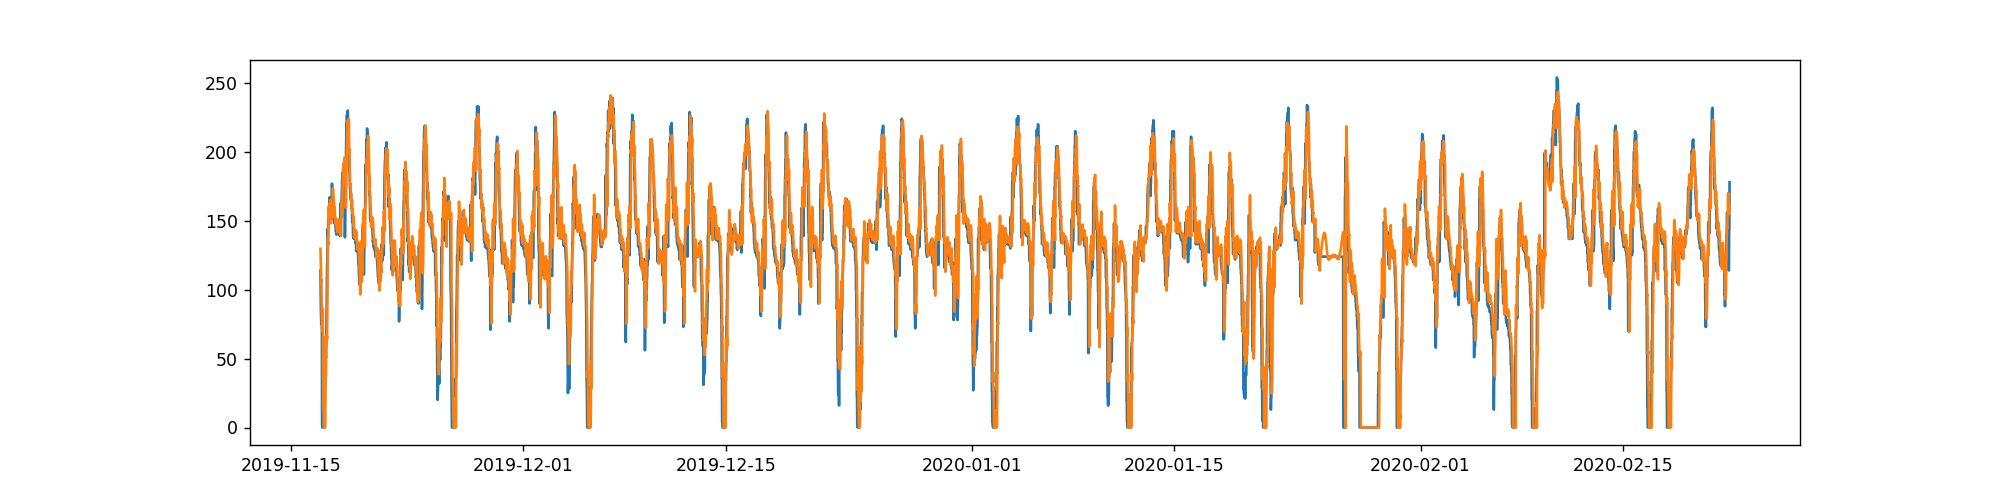

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import load_model

model.load_weights('model_checkpoint.h5')

# Calculating metrics 
# Choose how far into the future in 20 minute increments (so if 5 => (5+1)*20 = 120 mins into the future)
choose_future = 4
actual = y_test.T[choose_future][:]
predicted = model.predict(x_test).T[choose_future][:-future]
actual_denormalized = denormalize(test_means, test_stds, actual) * capacity
predicted_denormalized = denormalize(test_means, test_stds, predicted) * capacity
actual_change = actual[1:] - actual[:-1]
predicted_change = predicted[1:] - predicted[:-1]
MAE = MeanAbsoluteError()
MSE = MeanSquaredError()
MAPE = MeanAbsolutePercentageError()
MAE.update_state(actual*100, predicted*100)
MSE.update_state(actual_denormalized, predicted_denormalized)
MAPE.update_state(actual, predicted)
print('R-squared: ', r2_score(actual, predicted))
print('MAE: ', MAE.result().numpy())
print('MSE: ', MSE.result().numpy())
print('MAPE: ', MAPE.result().numpy())
# modify choose_future to change how far into the future the graph would display
start_date = dt.datetime.fromtimestamp(1573934430)
n = y_test.shape[0]-past

# denormalizing prediction and test and then plotting
plt.figure(figsize=(16, 4))
y_day = model.predict(x_test).T[choose_future][0:n]
y_day = denormalize(test_means, test_stds, y_day)
x_day = [start_date + dt.timedelta(minutes=i*20) for i in range(n)]
plt.plot(x_day, denormalize(test_means, test_stds, y_test.T[choose_future][0:n])*capacity)
plt.plot(x_day, y_day*capacity)
plt.show()

In [59]:
# import tensorboard
# %load_ext tensorboard
# %tensorboard --logdir logs

In [37]:
score_indexes = grid_result.cv_results_['rank_test_score']
print(grid_result.cv_results_)
for rank in (range(1, 15)):
    score_rank_index = np.where(score_indexes==rank)[0][0]
    print(grid_result.cv_results_['params'][score_rank_index])
    print(grid_result.cv_results_['mean_fit_time'][score_rank_index])
    print(grid_result.cv_results_['mean_test_score'][score_rank_index])
    print('=========================================')

{'mean_fit_time': array([13.93660126, 13.1173996 , 15.27240014, 13.76510215, 15.46310258,
       13.36780601]), 'std_fit_time': array([5.68512884, 5.13967752, 6.34167237, 5.34865268, 6.16380457,
       5.12519628]), 'mean_score_time': array([0.11499877, 0.1130003 , 0.1624001 , 0.12219996, 0.12479954,
       0.11759939]), 'std_score_time': array([0.00606592, 0.00404903, 0.05828677, 0.00160069, 0.01081488,
       0.00205906]), 'param_attention': masked_array(data=[False, False, False, False, False, False],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_batchNormalization': masked_array(data=[True, True, True, True, True, True],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_cnn': masked_array(data=[True, True, True, True, True, True],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), '

IndexError: index 0 is out of bounds for axis 0 with size 0

In [49]:
score_indexes = grid_result.cv_results_['rank_test_score']
grid_result.cv_results_

{'mean_fit_time': array([  5.93330317,   7.19832702,   9.15407972,   5.9841814 ,
          7.86002669,   9.83172655,   6.90207472,   8.81935158,
         10.58396297,   6.78050222,   8.73274679,  10.95549774,
          7.33186092,   8.77284737,  11.18288584,   7.18578181,
          9.3133955 ,  11.62979922,   7.43459926,   9.5771997 ,
         11.85399446,   7.75620003,   9.85859561,  12.4775671 ,
          8.30119581,  10.26759992,  12.45959864,   8.63339458,
         11.02023301,  13.44620013,   9.14200039,  11.22939939,
         13.92179499,   9.42399936,  11.81320004,  14.12959843,
          9.69519954,  11.63960061,  14.70219264,  10.78367066,
         12.63991809,  15.40774441,  10.79032125,  13.56342196,
         16.12709851,  11.43321009,  13.36259069,  16.14191194,
         22.12550497,  26.8082396 ,  32.64700942,  23.37371316,
         27.04928012,  33.68914695,  24.0028955 ,  28.8325624 ,
         35.38300285,  24.48743372,  28.75670304,  35.15321231,
         26.13174992,  

In [68]:
for rank in (range(1, 30)):
    score_rank_index = np.where(score_indexes==rank)[0][0]
    print(grid_result.cv_results_['params'][score_rank_index])
    print(grid_result.cv_results_['mean_fit_time'][score_rank_index])
    print(grid_result.cv_results_['mean_test_score'][score_rank_index])
    print('=========================================')

{'attention': True, 'batchNormalization': True, 'cnn': True, 'epochs': 60, 'kernels': 3, 'loss': 'mae', 'lr': 0.001, 'pool_size': 1, 'units': 64}
32.88250703811646
-0.02637312149122099
{'attention': False, 'batchNormalization': True, 'cnn': True, 'epochs': 60, 'kernels': 2, 'loss': 'mae', 'lr': 0.001, 'pool_size': 2, 'units': 64}
55.147796106338504
-0.029228726708386
{'attention': False, 'batchNormalization': True, 'cnn': True, 'epochs': 30, 'kernels': 2, 'loss': 'mae', 'lr': 0.001, 'pool_size': 1, 'units': 64}
27.853037214279176
-0.029373636023644727
{'attention': True, 'batchNormalization': True, 'cnn': True, 'epochs': 60, 'kernels': 3, 'loss': 'mae', 'lr': 0.001, 'pool_size': 2, 'units': 64}
35.31780066490173
-0.029605024619401992
{'attention': False, 'batchNormalization': True, 'cnn': True, 'epochs': 60, 'kernels': 2, 'loss': 'mae', 'lr': 0.001, 'pool_size': 1, 'units': 64}
63.10104432106018
-0.02961161771824583
{'attention': True, 'batchNormalization': True, 'cnn': True, 'epochs':

batchNormalization = True and lr = 0.001 are all in the top 15, epochs = 60 seems to give best result, but not much different from epochs = 30 so not worth the training time difference. Also, Mean Absolute Error gives better results for the top 10 results

In [16]:
# Trains all the models for all the carparks, should be used in the GPU Machine when access is given to us

training_split_fraction = 0.99 # modify train/test split, change to 1 for final model
skip_row = 1 + 0 # number of rows to skip (+ 1 because skipping is 2 or above) 
                 # so, for example, skip_row = 2, df is in increments of 30 mins
                 # skip_row = 3, df is increments of 30 mins, etc.
past = 15 # Number of past lot availabiltiy in a sequence
future = 12 # predict future * 10 mins from current, so if future = 3, predicts 30 minutes into future
features_selected = ['lots_available', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos']
# Looping through all the Car Parks and creating a CNN model for each one
for parking_area_df in df_list_by_number:
    capacity = int(parking_area_df['total_lots'].iloc[0])
    parking_area_df['lots_available'] = parking_area_df['lots_available'].astype(int)
    available_normalized = normalize(parking_area_df['lots_available'].astype(int).to_numpy())
    available_standardized = preprocessing.scale(parking_area_df['lots_available'].to_numpy())
    parking_area_df = parking_area_df[::skip_row]
    n_training = int(training_split_fraction * len(parking_area_df))
    n_testing = len(parking_area_df) - n_training

    df_features = parking_area_df[features_selected].to_numpy()
    x = []
    for i in range(past, len(parking_area_df)):
        x.append(df_features[i-past:i])

    x = np.array(x[:len(parking_area_df)-past])
    x = x.reshape(x.shape[0], x.shape[1], len(features_selected))
    df_available = parking_area_df['lots_available'].to_numpy()
    y = []
    for i in range(future):
        y.append(df_available[past+(i):i-future])

    y = np.array(y).T
    _, _, x_normalized = normalize(x)
    _, _, y_normalized = normalize(y)
    _, _, x_train = normalize(x[:n_training])
    _, _, x_test = normalize(x[n_training:])
    _, _, y_train = normalize(y[:n_training])
    # means and stds needed for y_test for de-normalization, but not needed for the rest
    # note that denormalization should be removed if using percentage instead of original normalization
    test_means, test_stds, y_test = normalize(y[n_training:])
    
    model = createModel(cnn=True, units=64, attention=False, lr=0.001, loss='mae', epochs=60, batchNormalization=True, kernels=3, pool_size=2, dilation_rate=2)
    checkpoint = ModelCheckpoint('trained_models/model_checkpoint_%s.h5' % (parking_area_df['carpark_number'].iloc[0]),monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    hist = model.fit(x_train, y_train, epochs=60, validation_data=(x_test[:len(y_test)], y_test), batch_size=32, callbacks=[checkpoint])

Epoch 1/60
1091/1091 [==============================] - 3s 2ms/step - loss: 0.1402 - mse: 0.0480 - root_mean_squared_error: 0.2056 - val_loss: 0.0605 - val_mse: 0.0071 - val_root_mean_squared_error: 0.0841
Epoch 2/60
1091/1091 [==============================] - 2s 2ms/step - loss: 0.0576 - mse: 0.0066 - root_mean_squared_error: 0.0810 - val_loss: 0.0589 - val_mse: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 3/60
1091/1091 [==============================] - 2s 2ms/step - loss: 0.0520 - mse: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0923 - val_mse: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 4/60
1091/1091 [==============================] - 2s 2ms/step - loss: 0.0496 - mse: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0563 - val_mse: 0.0055 - val_root_mean_squared_error: 0.0743
Epoch 5/60
 450/1091 [===========>..................] - ETA: 0s - loss: 0.0504 - mse: 0.0051 - root_mean_squared_error: 0.0713

KeyboardInterrupt: 

In [14]:
combined_df_sorted['month'].unique()

array(['11', '12', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
      dtype=object)

In [67]:
import matplotlib.pyplot as plt
%matplotlib notebook
df_list_by_number[715].head(75)

,carpark_number,update_datetime,year,month,day,hour,minute,second,total_lots,lot_type,...,car_park_type,type_of_parking_system,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
25207021,Y57,2019-11-16T23:57:57,2019,11,17,0,0,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,0.000000,1.000000e+00,0.000000e+00,1.000000e+00
25207023,Y57,2019-11-17T00:14:05,2019,11,17,0,15,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,0.000000,1.000000e+00,1.000000e+00,2.832769e-16
25207025,Y57,2019-11-17T00:29:11,2019,11,17,0,30,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,0.000000,1.000000e+00,5.665539e-16,-1.000000e+00
25207027,Y57,2019-11-17T00:43:30,2019,11,17,0,45,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,0.000000,1.000000e+00,-1.000000e+00,-1.836970e-16
25207029,Y57,2019-11-17T00:57:30,2019,11,17,1,0,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,0.258819,9.659258e-01,0.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25207101,Y57,2019-11-17T17:28:54,2019,11,17,17,30,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,-0.965926,-2.588190e-01,5.665539e-16,-1.000000e+00
25207102,Y57,2019-11-17T17:44:49,2019,11,17,17,45,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,-0.965926,-2.588190e-01,-1.000000e+00,-1.836970e-16
25207103,Y57,2019-11-17T17:59:26,2019,11,17,18,0,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,-1.000000,-1.836970e-16,0.000000e+00,1.000000e+00
25207104,Y57,2019-11-17T18:13:48,2019,11,17,18,15,30,21,C,...,SURFACE CAR PARK,ELECTRONIC PARKING,-0.5,0.866025,0.433884,-0.900969,-1.000000,-1.836970e-16,1.000000e+00,2.832769e-16


In [3]:
# Getting Latitude and Longitude of all the Car Parks using the LTA DataMall API
# getting carpark locations from LTA DataMall
info_df = pd.read_csv('hdb-carpark-information.csv')
requestJsonList = []
for i in range(5):
    response = requests.get('http://datamall2.mytransport.sg/ltaodataservice/CarParkAvailabilityv2?$skip='+str((i*500)), headers={'AccountKey': 'I2iOiPWPQwSYU0HjKgZb1A=='})
    requestJsonList.append(response.json())
jsonList = []
for requestJson in requestJsonList:
    for value in requestJson['value']:
        if (value['Agency'] == 'HDB'):
            jsonList.append(value)

In [4]:
# adding lat-lng to the carpark information
# then saving as csv
def latLngSplitter(location):
    split  = location.split(' ')
    return split[0], split[1]
df = pd.DataFrame(jsonList)
combined_df = df.merge(info_df, left_on='CarParkID', right_on='car_park_no').drop(['x_coord', 'y_coord'], axis=1).reset_index().transpose()
combined_df = combined_df.transpose().drop(['Area', 'index', 'Development', 'car_park_no', 'Agency', 'AvailableLots'], axis=1)
combined_df = combined_df[combined_df['LotType'] == 'C']
latList = []
lngList = []
for location in combined_df['Location']:
    lat, lng = latLngSplitter(location)
    latList.append(lat)
    lngList.append(lng)
combined_df['lat'] = latList
combined_df['lng'] = lngList
combined_df = combined_df.drop(['Location', 'LotType'], axis=1)
combined_df.to_csv('hdb-carpark-information-with-lat-lng.csv')
combined_df

,CarParkID,address,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,gantry_height,car_park_basement,lat,lng
0,A2,BLK 206/207 ANG MO KIO STREET 22,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,0,N,1.366237056,103.8430464
1,A4,BLK 217/220 ANG MO KIO AVENUE 1,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,4.5,N,1.365691621,103.8411922
2,A7,BLK 212/213 ANG MO KIO STREET 23,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,4.5,N,1.368392487,103.8413018
3,A8,BLK 209/210 ANG MO KIO STREET 22,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,4.5,N,1.368756071,103.8433077
4,A9,BLK 202/203 ANG MO KIO STREET 22,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,4.5,N,1.36807437,103.8443922
...,...,...,...,...,...,...,...,...,...,...,...,...
2137,Y70M,BLK 506 YISHUN AVE 4,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,16,2.15,N,1.414855443,103.8403692
2138,Y71M,BLK 501 YISHUN ST 51,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,7,2.15,N,1.41657976,103.840908
2139,Y73M,BLOCK 671 YISHUN AVENUE 4,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,14,2.15,N,1.41913521,103.8415629
2140,Y74M,BLOCK 673 YISHUN AVENUE 4,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,14,2.15,N,1.419627737,103.8416902


In [143]:
# converting dataframe to dictionary and saving it as json
combined_df.transpose().to_json('test.json')

In [5]:
merged_df.set_index('carpark_number')[['lots_available']].T.to_json('hdb-carpark-information.json')

In [7]:
merged_df['free_parking'].unique()

array(['SUN & PH FR 7AM-10.30PM', 'NO', 'SUN & PH FR 1PM-10.30PM'],
      dtype=object)